 # 沪深300指数纯因子组合构建

 > WIFA量化组，2019年春。

 依据多因子模型，尝试对沪深300指数构建纯因子组合。

 # Step 1：因子数据库构建

 因子数据分为**风格因子**和**风险因子**。

 其中风格因子又分为大类因子和细分类因子，最终风格因子会由细分类因子合成。

 风格因子共选取以下7个大类中的19个因子：

 - VALUE：EPS_TTM/P、BPS_LR/P、CFPS_TTM/P、SP_TTM/P
 - GROWTH：NetProfit_SQ_YOY、Sales_SQ_YOY、ROE_SQ_YOY
 - PROFIT：ROE_TTM、ROA_TTM
 - QUALITY：Debt2Asset、AssetTurnover、InvTurnover
 - MOMENTUM：Ret1M、Ret3M、Ret6M
 - VOLATILITY：RealizedVol_3M、RealizedVol_6M
 - LIQUIDITY：Turnover_ave_1M、Turnover_ave_3M

 风险因子选取以下2个大类中的2个因子：

 - INDUSTRY：中信一级行业
 - SIZE：Ln_MarketValue

 由于数据限制和平台选择，最终确定的因子和最初选取的因子比较如下：

 最初选取因子|最终确定因子|因子解释
 :--:|:--:|:--:
 EPS_TTM/P|PE_TTM|市盈率
 BPS_LR/P|PB_LYR|市净率
 CFPS_TTM/P|PCF_NCF_TTM|市现率（现金净流量）
 SP_TTM/P|PS_TTM|市销率
 NetProfit_SQ_YOY|YOYPROFIT|净利润同比增长率
 Sales_SQ_YOY|YOY_OR|营业收入同比增长率
 ROE_SQ_YOY|YOYROE|净资产收益率同比增长率
 ROE_TTM|ROE_TTM2|净资产收益率
 ROA_TTM|ROA_TTM2|总资产净利率
 Debt2Asset|DEBTTOASSETS|资产负债率
 AssetTurnover|ASSETSTURN|总资产周转率
 InvTurnover|INVTURN|存货周转率
 Ret1M|PCT_CHG|涨跌幅
 Ret3M|PCT_CHG|涨跌幅
 Ret6M|PCT_CHG|涨跌幅
 RealizedVol_3M|UNDERLYINGHISVOL_90D|90日历史波动率
 RealizedVol_6M|UNDERLYINGHISVOL_90D|90日历史波动率
 Turnover_ave_1M|TECH_TURNOVERRATE20|20日平均换手率
 Turnover_ave_3M|TECH_TURNOVERRATE60|60日平均换手率
 中信一级行业列表|INDUSTRY_SW|申万行业名称
 Ln_MarketValue|VAL_LNMV|对数市值

 > （注：Ret1M, Ret3M, Ret6M皆由PCT_CHG合成；RealizedVol_3M, RealizedVol_6M皆由UNDERLYINGHISVOL_90D代替。）
 >
 > 数据来源为万德金融数据库，通过WindPy API获取。
 >
 > 其中“最终确定因子”列即为其万德指标字段名。
 >
 > （数据保存在“H3 Data” ("HS300 Data" 的缩写) 文件夹中，格式为CSV，直接用全小写的万德指标名命名。
 > 即 "<万德指标名>.csv"，如 "pe_ttm.csv"）
 >
 > - 获取与存储数据的代码详见“H3 Codes/Data Fetching and Storing.py” 文件。
 >
 > - 获取的原始数据储存在"H3 Data/Raw Data"文件夹里。
 >

 数据格式如下：

 行/列 | 股票代号（000001.SZ）
 :--|--:
 交易日期（YYYYMMDD） | 相应因子暴露

 > 加载所需模块。

In [49]:
import os                                    # for getting working directory.
path = os.getcwd()                           # current working directory.
import pandas as pd                          # for wrapping csv file.
import numpy as np                           # for numerical manipulation.
import seaborn as sns                        # for plotting.
sns.set(style = "darkgrid")                  # set seaborn style.
import matplotlib.pyplot as plt              # specify "plt".
plt.rcParams['font.sans-serif'] = ['SimHei'] # For displaying chinese.
plt.rcParams['axes.unicode_minus']=False     # For displaying minus sign.


 # Step 2：因子数据处理

 > 对因子数据进行处理。

In [50]:
def get_factor_list():
    # The factor list stores the factor string I need.
    return [
        "pe_ttm", 
        "pb_lyr", 
        "pcf_ncf_ttm", 
        "ps_ttm", 
        "yoyprofit",
        "yoy_or", 
        "yoyroe", 
        # "roe_ttm",  # weired
        # "roa_ttm",  # weired
        "debttoassets", 
        "assetsturn", 
        "invturn",  
        "pct_chg", 
        # "underlyinghisvol_90d", 
        # "tech_turnoverrate20", 
        # "tech_turnoverrate60", 
        # "tech_turnoverrate120", 
        # "val_lnmv"
        # The last 5 data haven't been downloaded yet for quota exceeded.
    ]


In [51]:
def get_data(factor_name): 
    # Get data from disk.
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        forward-filled factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    data = pd.read_csv(
        open(
            # Extract raw data.
            path + "\\H3 Data\\Raw Data\\" + factor_name + ".csv", 
            'r', # read-only mode for data protection.
            encoding = "utf-8"
        ), 
        index_col = [0]
    )
    # Forward-fill nan to make quarter report fill the month.
    data.fillna(method = 'ffill', inplace = True)
    # Make all date format as "YYYYMMDD".
    data.index = pd.to_datetime(data.index).strftime('%Y%m%d')
    return data


In [52]:
def get_values(data):
    '''
    Parameter:
        data: input data. (pd.DataFrame)
    Return:
        a list of all values in data except nan. (list)
    '''
    # Collect all non-nan value into data_list.
    value_list = []
    for i in range(len(data.columns)): 
        # is there a way to avoid loop?
        value_list += data.iloc[:, i].dropna().tolist()
    return value_list


In [53]:
def overview():
    '''
    Return:
        save a 3*3 histogram distribution plot of original data.
    '''
    # Get an overview of 9 of the factors histogram distribution plot.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = get_data(get_factor_list()[i])
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("不同因子在A股的历史数据分布")


 如图为任取9个因子的沪深300的暴露数据在2005~2018年分布统计图。👇

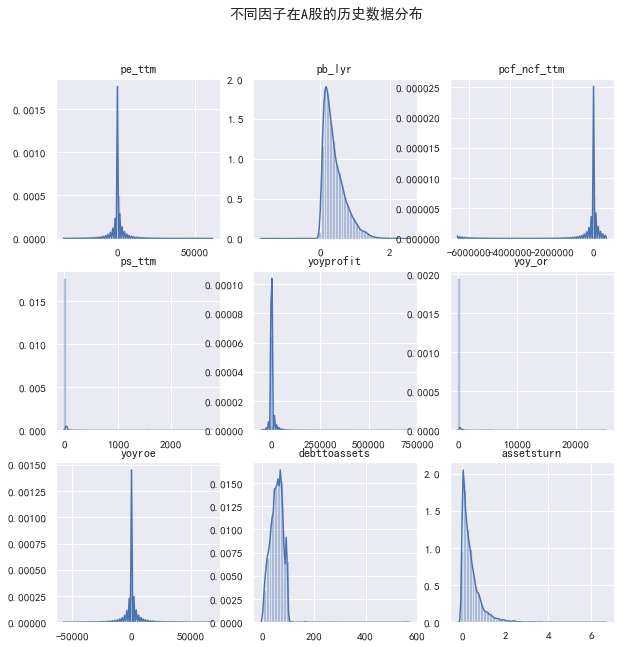

In [54]:
overview()


 从图中可以看出绝大多数因子都存在极差过大、分布不均的现象。
 而过大或过小的数据会影响到统计分析的结果，所以需要对数据进行处理。

 ## 2.1 填补缺失值
 由于万德输出的当季度财务数据只在报告期有数据，而在该季度的其他月份没有数据，所以针对这个现象采用“**向前填充**”来填补缺失值。

 ```Python3
 data.fillna(method = 'ffill', inplace = True)
 ```

In [55]:
def get_unfilled_data(factor_name): 
    # Get data from disk.
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        forward-filled factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    data = pd.read_csv(
        open(
            # Extract raw data.
            path + "\\H3 Data\\Raw Data\\" + factor_name + ".csv", 
            'r', # read-only mode for data protection.
            encoding = "utf-8"
        ), 
        index_col = [0]
    )
    # # Forward-fill nan to make quarter report fill the month.
    # data.fillna(method = 'ffill', inplace = True)
    # Make all date format as "YYYYMMDD".
    data.index = pd.to_datetime(data.index).strftime('%Y%m%d')
    return data


 填补前：

In [56]:
get_unfilled_data("pe_ttm").head(12)


,000001.SZ,000002.SZ,000063.SZ,000069.SZ,000100.SZ,000157.SZ,000166.SZ,000333.SZ,000338.SZ,000402.SZ,...,603156.SH,603160.SH,603259.SH,603260.SH,603288.SH,603799.SH,603833.SH,603858.SH,603986.SH,603993.SH
20050131,28.856604,19.732817,21.487532,26.847097,14.534634,9.521501,NaN,NaN,NaN,20.626238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050228,30.856567,19.802299,24.165710,29.290787,17.133249,10.488218,NaN,NaN,NaN,21.279558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050331,24.809061,14.294232,23.226406,29.792913,14.975077,8.011833,NaN,NaN,NaN,15.371941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050429,52.559383,13.089117,23.110903,33.623592,27.001915,8.774595,NaN,NaN,NaN,25.366234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050531,50.948692,10.315999,20.927197,26.973518,-17.498217,8.218870,NaN,NaN,NaN,22.397844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050630,50.270508,10.449360,19.965324,30.807489,-16.792011,9.008584,NaN,NaN,NaN,24.586657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050729,50.270508,12.778834,21.403799,31.146780,-15.144197,8.745346,NaN,NaN,NaN,26.775469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050831,74.881660,9.190952,20.595617,29.735195,-6.554149,11.595522,NaN,NaN,NaN,27.910452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050930,69.232483,9.015169,22.647072,31.069050,-6.711700,10.978922,NaN,NaN,NaN,28.587265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20051031,44.592522,9.991656,22.942987,31.481718,-3.875593,10.813002,NaN,NaN,NaN,14.041930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 填补后：

In [57]:
get_data("pe_ttm").head(12)


,000001.SZ,000002.SZ,000063.SZ,000069.SZ,000100.SZ,000157.SZ,000166.SZ,000333.SZ,000338.SZ,000402.SZ,...,603156.SH,603160.SH,603259.SH,603260.SH,603288.SH,603799.SH,603833.SH,603858.SH,603986.SH,603993.SH
20050131,28.856604,19.732817,21.487532,26.847097,14.534634,9.521501,NaN,NaN,NaN,20.626238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050228,30.856567,19.802299,24.165710,29.290787,17.133249,10.488218,NaN,NaN,NaN,21.279558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050331,24.809061,14.294232,23.226406,29.792913,14.975077,8.011833,NaN,NaN,NaN,15.371941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050429,52.559383,13.089117,23.110903,33.623592,27.001915,8.774595,NaN,NaN,NaN,25.366234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050531,50.948692,10.315999,20.927197,26.973518,-17.498217,8.218870,NaN,NaN,NaN,22.397844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050630,50.270508,10.449360,19.965324,30.807489,-16.792011,9.008584,NaN,NaN,NaN,24.586657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050729,50.270508,12.778834,21.403799,31.146780,-15.144197,8.745346,NaN,NaN,NaN,26.775469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050831,74.881660,9.190952,20.595617,29.735195,-6.554149,11.595522,NaN,NaN,NaN,27.910452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050930,69.232483,9.015169,22.647072,31.069050,-6.711700,10.978922,NaN,NaN,NaN,28.587265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20051031,44.592522,9.991656,22.942987,31.481718,-3.875593,10.813002,NaN,NaN,NaN,14.041930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 针对剩余的缺失数据，我们将在数据[标准化](##2.3标准化)处理后统一填充为零。

# 2.2 去极值

 去极值的方法采用调整因子值中的离群值至指定阈值的上下限，从而减小**离群值**和**极值**对统计的偏差。

 离群值的阈值上下限定义的方法主要有三种：

 1. MAD法
 2. 3σ法
 3. 百分位法

In [59]:
class Filter(object):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    '''
    def __init__(self, factor_name):
        data = get_data(factor_name)
        self.data = data
        self.values = get_values(
            data = data
        )
    
    def original(self):
        '''
        Return:
            original unfiltered data. (pd.DataFrame)
        '''
        return self.data
    
    def MAD(self, n = 100):
        '''
        Parameter:
            n: how many times new median. (int)
        Return:
            filtered data. (pd.DataFrame)
        '''
        median = np.percentile(self.values, 50)
        new_median = np.percentile(
            get_values(abs(self.data - median)), 50
        )
        min_range = median - n * new_median
        max_range = median + n * new_median
        return self.data.clip(min_range, max_range, axis = 1)
    
    def three_sigma(self, n = 3):
        '''
        Parameter:
            n: how many sigmas. (int)
        Return:
            filtered data. (pd.DataFrame)
        '''
        min_range = np.mean(self.values) - n * np.std(self.values)
        max_range = np.mean(self.values) + n * np.std(self.values)
        return self.data.clip(min_range, max_range, axis = 1)
    
    def percentile_filter(self, min = 1.5, max = 98.5):
        '''
        Parameters:
            min: minimum percentage. (float)
            max: maximum percentage. (float)
        Return:
            filtered data. (pd.DataFrame)
        '''
        min_range = np.percentile(self.values, min)
        max_range = np.percentile(self.values, max)
        return np.clip(self.data, min_range, max_range)


 ### 2.2.1 MAD法 (Median Absolute Deviation)

 取因子的中位数，加减每个因子与该中位数的绝对偏差值的中位数乘上给定参数（此处经过调参设定默认为100倍）得到上下阈值。

In [60]:
def overview_MAD():
    '''
    Return:
        save a 3*3 histogram distribution plot of 
        MAD-filtered data.
    '''
    # Get an overview of MAD method filtering.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = Filter(get_factor_list()[i]).MAD()
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("绝对值差中位数法(MAD法)去极值后")


 经过MAD法去极值后的因子数据概览如下：

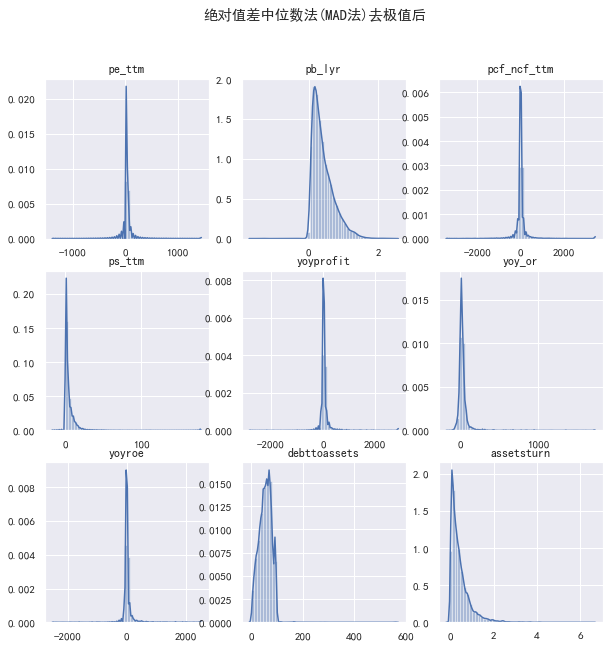

In [61]:
overview_MAD()


 ### 2.2.2 3σ法

 取所有因子数据的标准差（即σ），偏离平均值给定参数（此处默认为三倍）标准差处设为上下阈值。

In [62]:
def overview_three_sigma():
    '''
    Return:
        save a 3*3 histogram distribution plot of 
        3sigma-filtered data.
    '''
    # Get an overview of 3 sigma method filtering.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = Filter(get_factor_list()[i]).three_sigma()
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("3σ法去极值后")


 经过3σ法去极值后的因子数据概览如下：

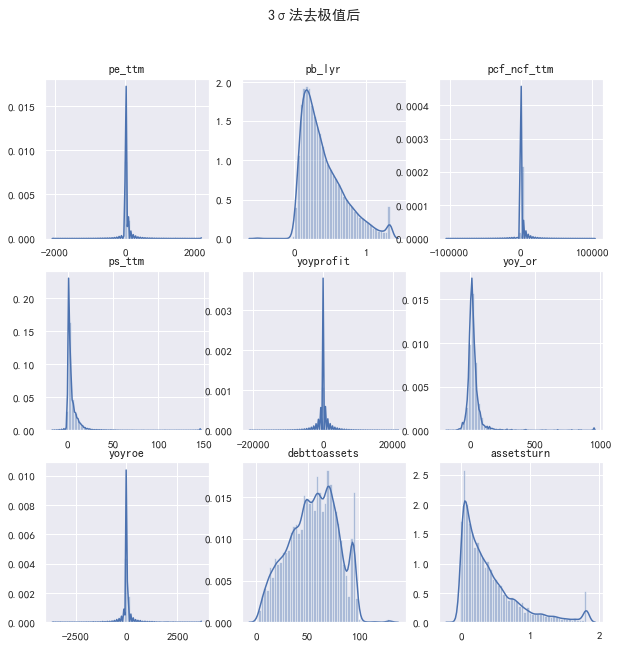

In [63]:
overview_three_sigma()


 ### 2.2.3 百分位法

 取给定百分位作为上下阈值。（此处经过调参设定为下限1.5%，上限98.5%分位点）

In [64]:
def overview_percentile():
    '''
    Return:
        save a 3*3 histogram distribution plot of 
        percentile-filtered data.
    '''
    # Get an overview of percentile method filtering.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = Filter(get_factor_list()[i]).percentile_filter()
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("百分位法去极值后")


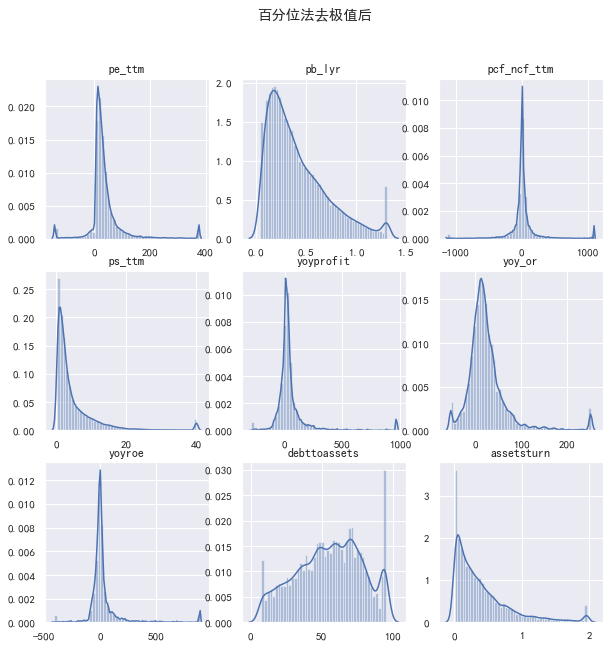

In [65]:
overview_percentile()


 ### 2.2.4 去极值研究。

 实际上，即使经过调参尽可能地使三种主流的去极值方法的结果互相接近，并不至于出现过于集中的阈值，仍然有可能出现非常显著不同的效果。

 以每股现金流为例，将原始数据和三种去极值的方法处理后的因子数据放在同一张图里，由于值域相差太大，甚至根本无法从图中找到不同的方法对应的图表。（如下图：分别采用三种去极值方法处理后的每股现金流数据与其原始数据图👇）

In [66]:
def huge_deviation_filter_method_comparison():
    '''
    Return:
        save a histogram distribution plot of 
        a hugely deviated data for different filter method comparison.
    '''
    plt.figure(figsize = (8, 5))
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").original()
    ), label = "Original")
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").MAD()
    ), label = "MAD")
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").three_sigma()
    ), label = "3σ")
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").percentile_filter()
    ), label = "Percentile")
    plt.legend()
    plt.title("不同去极值方法的比较（以每股现金流为例）")


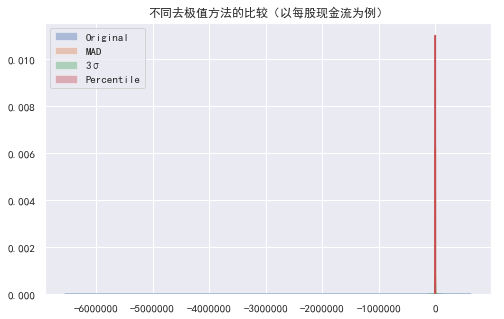

In [67]:
huge_deviation_filter_method_comparison()


 究其原因，是其原始数据的集中度就非常高，以至于不同方法去极值计算出相差甚远的阈值。（如下图：全部A股样本期内每股现金流的密度分布图👇）

In [68]:
def huge_deviation_original_data():
    '''
    Return:
        save a histogram distribution plot of 
        original data with huge deviation.
    '''
    plt.figure(figsize = (8, 5))
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").original()
    ), label = "Percentile")
    plt.legend()
    plt.title("每股现金流：原始数据")


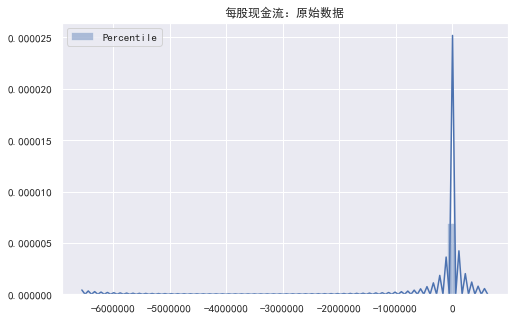

In [69]:
huge_deviation_original_data()


 所以经过百分位去极值后，尽管值域缩小了近6000倍，但仍然非常集中。

 另外，这种离差过大的数据去极值的时候还会出现一个问题：造成阈值部分出现异常高的“虚假”数据，而这也是我们不愿意看到的。（如下图：每股现金流经过约束最严格的百分位去极值处理后的分布图👇）

In [70]:
def huge_deviation_filtered_data():
    '''
    Return:
        save a histogram distribution plot of 
        percentile-filtered data with huge deviation.
    '''
    plt.figure(figsize = (8, 5))
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").percentile_filter()
    ), label = "Percentile")
    plt.legend()
    plt.title("每股现金流：百分位去极值")


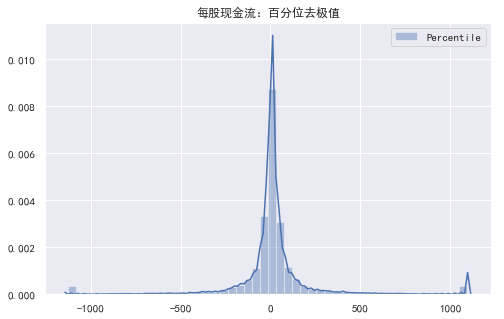

In [71]:
huge_deviation_filtered_data()


 > 注意图中 [-1000, 1000] 处异常的“突起”。
 >
 > 这是由于过多超出上下阈值的数据被迫调整为上下阈值，导致阈值处的数据分布特别密集。
 但在大多数情况下（数据分布相对均匀时，此处以ROE为例），各种方法以及原始数据相差不大。（如下图：资产周转率数据的原始数据及分别经过三种去极值方法处理后的分布图👇）

In [72]:
def filter_method_comparison():
    '''
    Return:
        save a histogram distribution plot of
        a normal data for different filter method comparison.
    '''
    plt.figure(figsize = (8, 5))
    sns.distplot(get_values(
        data = Filter("assetsturn").original()
    ), label = "Original")
    sns.distplot(get_values(
        data = Filter("assetsturn").MAD()
    ), label = "MAD")
    sns.distplot(get_values(
        data = Filter("assetsturn").three_sigma()
    ), label = "3σ")
    sns.distplot(get_values(
        data = Filter("assetsturn").percentile_filter()
    ), label = "Percentile")
    plt.legend()
    plt.title("不同去极值方法的比较（以资产周转率为例）")


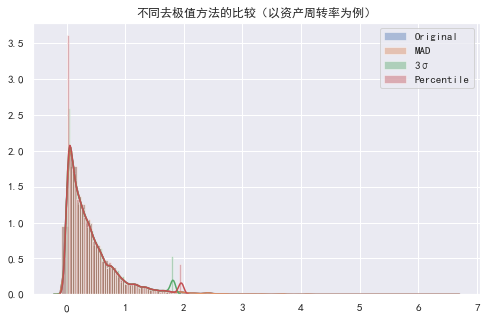

In [73]:
filter_method_comparison()


 经过比较研究，我们最终选取阈值选取相对最为合理，较少阈值异常“突起”，同时保留较宽值域的**参数值为100的MAD法**进行去极值处理。

 ## 2.3 标准化

 标准化处理数据的目的就是去除其**量纲**。

 这样做可以使得：

 - 数据更加集中
 - 不同数据之间可以互相比较和进行回归等

 主流的标准化的方法有两种：

 标准化方法|原理|优点|缺点
 :--|:--|:--:|:--:
 对原始因子值标准化|减去均值后，除以标准差|保留更多信息|对数据分布有要求
 对因子排序值标准化|因子排序值进行上述处理|适用性更广泛|非参数统计法

 它们都能使得数据的：

 - 均值为0
 - 标准差为1

 由于已经对数据进行去极值处理，我们最终选取对原始因子值进行标准化(z-score)的方法进行标准化。

In [74]:
# Use z-score method to standardize.
def standardize(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        standardized and Filtered (MAD) data. (pd.DataFrame)
    '''
    data = Filter(factor_name).MAD()
    data = data.fillna(0)
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std


 > 2.1， 2.2， 2.3的数据处理部分的：
 >
 > - 代码详见“H3 Codes/Data Processing.py” 文件。
 >
 > - 数据保存在"H3 Data/Processed Data"文件夹里。

In [75]:
def get_processed_data(factor_name): # get data from disk.
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        processed factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    data = pd.read_csv(
        open(
            path + "\\H3 Data\\Processed Data\\" + factor_name + ".csv", 
            'r', # read-only mode for data protection.
            encoding = "utf-8"
        ), 
        index_col = [0]
    )
    return data


In [76]:
def overview_processed_data():
    # Get an overview of processed data.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = get_processed_data(get_factor_list()[i])
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("经过处理后的A股因子数据密度分布图一览")


 （如下图为经过去极值、标准化处理后的数据密度分布图一览👇）

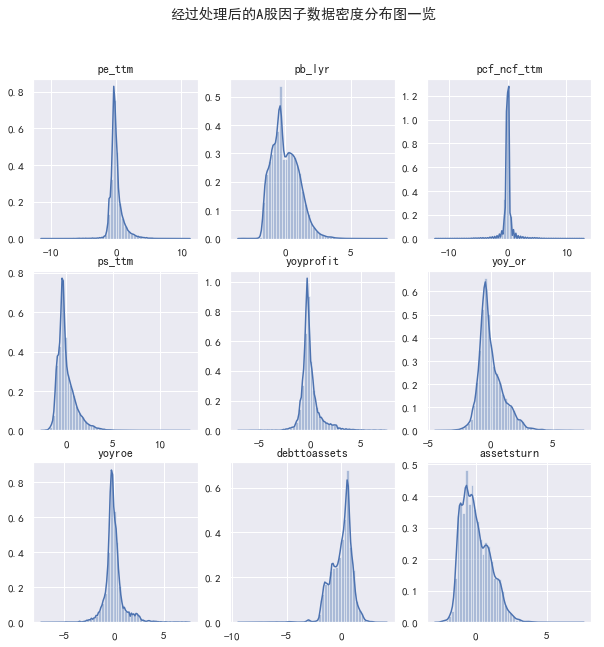

In [77]:
overview_processed_data()


# 2.4 中性化

 中性化的目的是剔除数据中多余的风险暴露。

 根据某些因子（指标）选股的时候，由于某些因子之间具有较强的相关性，故时常会有我们不希望看到的“**偏向**”，导致投资组合不够**分散**。

 例如以下四个指标：

 - 市现率
 - 净利润同比增长率
 - 净资产收益率同比增长率
 - 存货周转率

In [78]:
def get_industry_data():
    '''
    Return:
        SHENWAN industry data. (pd.DataFrame)      
    '''
    return get_processed_data("industry_sw")


In [79]:
def get_industry_list():
    '''
    Return:
        industry list in HS300 stocks list.
    '''
    return list(get_industry_data().iloc[:, 0].unique())


In [80]:
def industry_comparison(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        average factor value of each industries. (pd.DataFrame)
            index: industry. (str)
            columns: factor name. (str)
    '''
    # All industry in HS300.
    sw_industry_list = get_industry_list()
    # Use certain factor data for comparison example between industry.
    compare_data = get_data(factor_name)
    compare_industry = pd.DataFrame(
        index = sw_industry_list, 
        columns = [factor_name]
    )
    for industry in sw_industry_list:
        industry_stock_code_list = list(get_data("industry_sw")[
            get_data("industry_sw").iloc[:, 0] == industry
        ].index)
        # Some industry is not in HS300. 
        try:
            industry_data = compare_data[industry_stock_code_list]
            compare_industry.loc[
                industry, factor_name
            ] = np.mean(np.mean(industry_data))
        except:
            continue
    compare_industry.dropna(inplace = True)
    return compare_industry


In [81]:
def plot_industry_comparison():
    '''
    Return:
        save a 2*2 plot of average factor of each industries, 
        which are all siginificantly different. 
    '''
    # Choose 4 factors that's significantly different among industries. 
    significant_comparison_industry_list = [
        "pcf_ncf_ttm", 
        "yoyprofit", 
        "yoyroe", 
        "invturn"
    ]
    plt.figure(figsize = (21, 18)) # it's a big plot.
    for i in range(len(significant_comparison_industry_list)):
        plot_data = industry_comparison(
            significant_comparison_industry_list[i]
        )
        plt.subplot(int("22" + str(i+1)))
        sns.barplot(
            x = plot_data.index, 
            y = significant_comparison_industry_list[i], 
            data = plot_data
        )
        plt.xticks(rotation = 60) # rotate to avoid overlap text.
        plt.title(
            significant_comparison_industry_list[i], 
            fontsize = 21
        )
    plt.suptitle(
        "沪深300中不同行业部分因子平均值比较", 
        fontsize = 36
    )


 沪深300股票指数中共包含17个行业（根据申万一级行业分类），分别统计沪深300指数中各行业以上四个指标的平均值，结果如下图所示👇。

In [82]:
plot_industry_comparison()


ValueError: ('Unknown string format:', '000001.SZ')

 从图中可以看到，不同行业的不同指标相差十倍、千倍乃至万倍都有。

 > *有色金属行业的平均市现率是家用电器行业的负十八万倍。*

In [83]:
print(round(
    industry_comparison("pcf_ncf_ttm").loc["有色金属", "pcf_ncf_ttm"] /  
    industry_comparison("pcf_ncf_ttm").loc["家用电器", "pcf_ncf_ttm"] , 
    0
))


ValueError: ('Unknown string format:', '000001.SZ')

 那么，依据市现率因子选取出的股票必然对平均市现率高的行业有偏向，而我们希望投资组合中的行业尽可能分散，故我们希望对行业进行中性化。（同理，我们也希望对市值进行中性化。）

 中性化的主要做法就是通过回归得到一个与风险因子（行业因子、市值因子）**线性无关**的因子。（即线性回归后的残差项作为中性化后的新因子。）如此一来，中性化处理后的因子与风险因子之间的相关性就严格为零。

 > 不过这样做中性化并不一定总能彻底地剔除因子的多余信息。因为线性回归要求两个前提假设：
 >
 > - 因子之间线性相关
 > - 残差正态独立同分布
 >
 > 而在因子数据中这两个假设都不一定成立。（例如在[2.2去极值](##2.2去极值)步骤中密度过高的阈值就对数据的分布造成了破坏）

 但直观的说，根据[Brinson资产配置分析](https://www.investopedia.com/terms/a/attribution-analysis.asp)超额收益理论来看，如果投资组合中风险因子配置资产权重等于基准资产中其之权重，则做到了中性化。

 此处简便起见，我们依然采用线性回归作为中性化的处理方法。

 回归方式如下：

 - 被解释变量：前述数据处理后的因子数据

 - 解释变量：

   - 市值因子
   - 行业因子（作为指示变量）

 最终回归方程的**残差**项即为中性化后的因子暴露。

In [84]:
def get_industry_exposure(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        industry exposure data. (pd.DataFrame)
    '''
    file_path = path + "\\H3 Data\\Neutralized Data\\industry exposure " + factor_name + ".csv"
    if os.path.isfile(file_path):
        industry_exposure = pd.read_csv(
            open(
                file_path, 
                'r', 
                encoding = "utf-8"
            ), 
            index_col = [0]
        )
    else:
        # Don't know why but different factor data has different hs300 stocks list, 
        # so specify which factor is essential.
        hs300_stock_list = list(get_data(factor_name).columns)
        industry_exposure = pd.DataFrame(
            index = get_industry_list(), 
            columns = hs300_stock_list
        )
        for stock in hs300_stock_list:
            try:
                industry_exposure.loc[
                    get_industry_data().loc[
                        stock, 
                        "INDUSTRY_SW"
                    ], 
                    stock
                ] = 1
            except:
                continue
        industry_exposure.fillna(0, inplace = True)
        industry_exposure.to_csv(file_path)
    return industry_exposure


In [85]:
import math
from statsmodels import regression
import statsmodels.api as sm


In [86]:
def neutralize(
    factor_name, 
    market_capital = True, 
    industry = True
):
    '''
    Parameters:
        factor_name: name of factors in Wind. (str)
        market_capital: whether market-capital-neutralize or not. (bool)
        industry: whether industry-neutralize or not. (bool)
    Return:
        neutralized data. (pd.DataFrame)
    '''
    y = get_processed_data(factor_name).T.fillna(0) # don't know why but there's still nan.
    industry_dummy = get_industry_exposure(factor_name)
    if market_capital:
        ln_market_capital = get_data("val_lnmv")
        if industry:
            x = pd.concat(
                [
                    ln_market_capital, 
                    industry_dummy
                ], 
                axis = 1
            )
        else:
            x = ln_market_capital
    elif industry:
        x = industry_dummy.T
    result = sm.OLS(
        y.astype(float), 
        x.astype(float)
    ).fit()
    return result.resid.T


In [87]:
def plot_industry_neutralization(factor_name):
    '''
    Return: 
        a plot of neutralization comparison.
    '''
    plt.figure(figsize = (8, 5))
    sns.kdeplot(get_values(
        data = get_processed_data(factor_name)
    ), label = "未经中性化")
    sns.kdeplot(get_values(
        data = neutralize(
            factor_name, 
            market_capital = False, 
            industry = True
        )
    ), label = "行业中性化")
    plt.legend()
    plt.title("对" + factor_name + "进行中性化处理前后比较")


In [88]:
def overview_neutralization(factor_list):
    '''
    Parameter:
        factor_list: list of factor names. (list)
    Return:
        save a 2*2 plot of neutralization comparison.
    '''
    factor_list = factor_list
    plt.figure(figsize = (10, 10))
    for i in range(len(factor_list)):
        plt.subplot(int("22" + str(i+1)))
        sns.kdeplot(get_values(
            data = get_processed_data(factor_list[i])
        ), label = "未经中性化")
        sns.kdeplot(get_values(
            data = neutralize(
                factor_list[i], 
                market_capital = False, 
                industry = True
            )
        ), label = "行业中性化")
        plt.legend()
        plt.title("对" + factor_list[i] + "进行中性化处理前后比较")
    plt.suptitle("行业中性化的典型结果")


 （如下图，为选取四个因子指标进行行业中性化前后的结果，以展示中性化的一般结果👇，可以看出中性化导致分布更均匀、更接近均值）

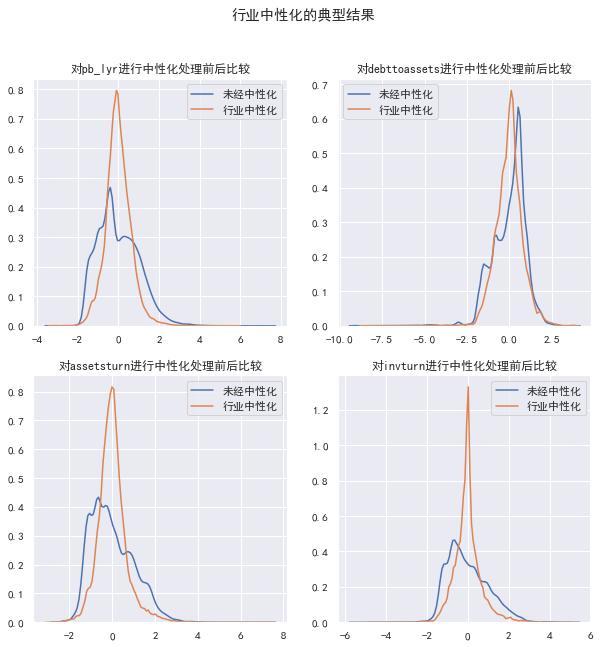

In [89]:
overview_neutralization([
    "pb_lyr", 
    "debttoassets", 
    "assetsturn", 
    "invturn"
])


 > 数据处理中性化部分的：
 >
 > - 代码详见“H3 Codes/Data Neutralization.py” 文件。
 > - 数据保存在"H3 Data/Neutralized Data"文件夹里。

In [90]:
def get_neutralized_data(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        neutralized factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    data = pd.read_csv(
        open(
            path + "\\H3 Data\\Neutralized Data\\" + factor_name + ".csv", 
            'r', # read-only mode for data protection.
            encoding = "utf-8"
        ), 
        index_col = [0]
    )
    return data


In [91]:
def overview_after_data_processing():
    # Get an overview of data after processing.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        factor_name = get_factor_list()[i]
        sns.distplot(get_values(
            data = get_neutralized_data(factor_name)
        ))
        plt.title(factor_name)
    plt.suptitle("经过数据处理后的不同因子在A股的历史数据分布")


 最终经过所有因子数据处理步骤之后，原来的因子数据分布图变为了这样。

 （经过所有数据处理步骤后的因子数据密度分布图一览👇）

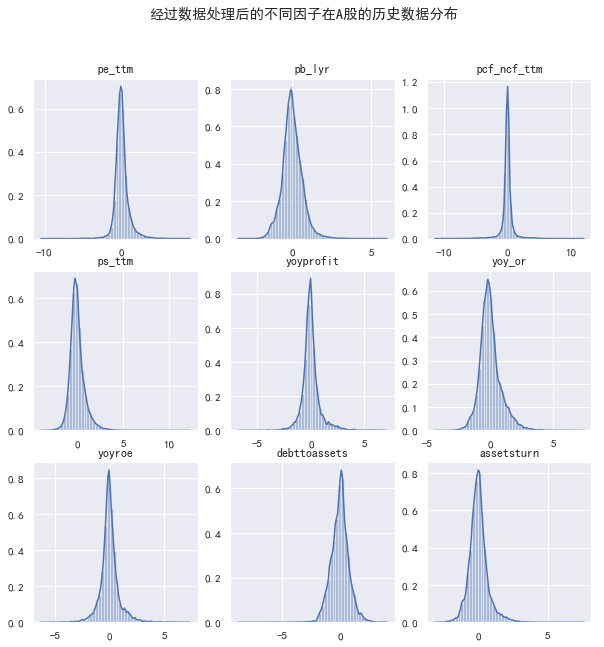

In [92]:
overview_after_data_processing()


 可以看出数据经过处理后分布变得更加接近标准正态分布了一些。

 ![Before & After.jpg](https://i.loli.net/2019/02/25/5c7406655137f.jpg)

 # Step 3：大类因子合成

 前面两个步骤已经把风格因子的细分类因子数据经过数据处理并保存了下来，这一步把细分类因子合成为大类因子。使得最终合成后只剩下：

 - VALUE
 - GROWTH
 - PROFIT
 - QUALITY
 - VOLATILITY
 - MOMENTUM
 - LIQUIDITY

 这七个因子，我们的目标就是构建这七个因子的**纯因子组合**。

 > 从这一步开始为方便提取数据，将数据从"pandas.DataFrame"转换为"pandas.PanelData"。
 >
 > 数据格式为：
 >
 > - index: stock codes
 > - factor names
 >
 > 可以用以下方法提取特定时间的所有因子的所有股票数据：
 >
 > ```Python3
 > Large_factor.major_xs("20050131")
 > ```

In [93]:
# Make get_data identical to get_neutralized_data.
def get_data(factor_name):
    return get_neutralized_data(factor_name)


In [94]:
# Turn dataframe into panel data. 
def get_group_data(factor_list):
    '''
    Parameter:
        factor_list: list of factor names. (str list)
    Return:
        panel data of all factors data. (pd.Panel)
    '''
    datadict = {}
    for i in factor_list:
        df = get_neutralized_data(i) # this should be the processed data
        datadict[i] = df
    panel = pd.Panel(datadict)
    return panel


In [95]:
class Large_factor_merge(object):
    '''
    Parameters:
        Large_factor: large factor data. (pd.Panel)
    '''
    def __init__(self, Large_factor):
        if Large_factor == 'VALUE':
            list = ["pe_ttm","pb_lyr","pcf_ncf_ttm","ps_ttm"]
        elif Large_factor =='GROWTH':
            list = ["yoyprofit","yoy_or","yoyroe"]
        elif Large_factor =='PROFIT':
            list = ["roe_ttm","roa_ttm"]
        elif Large_factor == 'QUALITY':
            list = ["debttoassets","assetsturn","invturn"]
        elif Large_factor =='MOMENTUM':
            list = ['pct_chg'] # This will be modified
        elif Large_factor =='VOLATILITY':
            list = ["underlyinghisvol_90d","tech_turnoverrate20"]
        elif Large_factor == 'LIQUIDITY':
            list = ["tech_turnoverrate60","tech_turnoverrate120"]
        data = get_group_data(list)
        self.data = data
        self.Large_factor = Large_factor
    # Define the following function for you can read clearly and can acquire the data of every step.
    def Caculate_IC(self):
        '''
        Return:
            IC of Large Factor.         
        '''
        stock_return = get_data('pct_chg')# This will be modified
        datadict = {}
        for i in self.data.items:
            df = self.data[i]
            IC = pd.DataFrame(columns=['IC_monthly'],index = df.index[0:len(df)-1])
            IC_group = []
            for j in range(len(df)-1):
                cor = df.iloc[j].corr(stock_return.iloc[j+1])
                IC_group.append(cor)
            IC['IC_monthly'] = IC_group
            datadict[i] = IC
        IC_Large = pd.Panel(datadict)
        return IC_Large

    def Caculate_IR(self):
        '''
        Return:
            IR of Large Factor. 
        '''
        IC_Large = self.Caculate_IC()
        weight_df = pd.DataFrame(columns=['weights'],index=self.data.items)
        weight = []
        for i in IC_Large.items:
            df = IC_Large[i]
            IR = df.iloc[-24:,0].mean()/df.iloc[-24:,0].std()
            weight.append(IR)
        weight = [x/sum(weight) for x in weight] #adjust the sum of weight to 1.0
        weight_df['weights'] = weight
        return weight_df

    def Factors_merge(self):
        '''
        Return:
            the merged large factor data.
        '''
        weight = self.Caculate_IR()
        # I don't find more attribute for panel data for sum.
        Factors_sum = pd.DataFrame(0,columns=self.data.minor_axis,index=self.data.major_axis)
        for i in self.data.items:
            df = self.data[i]
            new_df = df*weight.loc[i,'weights']
            Factors_sum = Factors_sum +new_df
        return Factors_sum


In [96]:
Factor_dict = {}
for i in ['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY']:
    Factor_data = Large_factor_merge(i).Factors_merge()
    Factor_dict[i] = Factor_data
Large_factor = pd.Panel(Factor_dict)
# when you want to use one factor,you can edit'Large_factor[the name of the factor]'


C:\Users\kaspe\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



IndexError: single positional indexer is out-of-bounds